# Model Ensembling

In this notebook, I will combine the three trained model that were previously tuned.

### Used Algorithms

1. XGB - Extreme Gradient Boosting

2. Cat Boost

3. Random Forest Classifier

Ensembling was done using a bagging approach by using custom defined weights. The Ensembling model was made by using the trained models rather than making the ensembled model trainable.

## Loading Data and Performing Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os

path = os.path.join('Training_Features', 'Splitted_Dataset_Features_3sec.csv')
df = pd.read_csv(path)

label_enc = {}
for i, label in enumerate(df.Label.unique()):
  label_enc[label] = i

#Shuffling and encoding
df.Label = df.Label.apply(lambda label : label_enc[label])
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)[['File_Name','Label']]

#Separating features and label
df_X = df.drop(columns = ['File_Name', 'Label'])
df_y = df.pop('Label')

#Scaling Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
cols = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns = cols)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_test.head()

,Tempo,Chroma_STFT_Mean,Chroma_STFT_Var,RMS_Mean,RMS_Var,Spectral_Centroid_Mean,Spectral_Centroid_Var,Spectral_Bandwidth_Mean,Spectral_Bandwidth_Var,Spectral_Rolloff_Mean,...,MFCC16_Mean,MFCC16_Var,MFCC17_Mean,MFCC17_Var,MFCC18_Mean,MFCC18_Var,MFCC19_Mean,MFCC19_Var,MFCC20_Mean,MFCC20_Var
0,-0.383492,0.960168,-0.608233,-0.801789,-0.080982,0.188449,-0.148340,-0.454528,-0.769187,-0.076337,...,0.713178,0.466876,-0.450443,0.060847,-0.611193,0.572019,1.028404,0.148595,1.017802,-0.149192
1,0.343002,-1.212966,0.421506,-1.337306,-0.668549,0.269159,0.576324,0.149060,-0.049879,0.334764,...,3.200396,1.873193,1.305463,1.226786,-0.145717,-0.800828,-1.965780,0.518930,-1.641870,-0.104905
2,-0.659559,0.463157,-0.249977,-0.494953,-0.313110,0.356037,-0.239739,-0.045383,-0.609652,0.246891,...,0.765066,0.233639,1.446397,-0.416016,1.559500,-0.076627,1.309087,-0.116087,0.526438,-0.571235
3,-1.745667,1.794101,-1.416978,-0.265929,-0.157750,0.590985,-0.597413,0.216176,-0.862027,0.497690,...,0.952012,0.459194,-0.177617,-0.312887,0.489187,-0.240889,-0.415215,-0.176538,-0.323370,0.684447
4,-1.188689,-1.058357,0.556022,-1.180908,-0.704526,-0.283583,-0.785953,-0.489648,-0.942092,-0.321432,...,2.345543,4.249146,1.303362,1.061469,0.940202,0.356191,-2.846833,1.492555,-1.074389,0.663384


## Helper Function

A function to quickly validate the model by plotting the confusion matrix and printing the classification report.

Can be used either with training data or test data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def model_report(clf, test_data=False, conf_matrix=True, class_report=True):

  X, y = X_train, y_train
  if test_data:
    X, y = X_test, y_test
  y_preds = clf.predict(X)

  #Plotting Confusion Matrix 
  if conf_matrix:
    fig = plt.figure(figsize=(8,12))
    ConfusionMatrixDisplay.from_predictions(y, y_preds, display_labels=label_enc.keys(), cmap='BuPu', 
                                            ax=plt.gca(), colorbar=False, xticks_rotation=90)

    plt.tick_params(axis='both', pad=4, labelsize='large')
    plt.title('Confusion Matrix for {}'.format(str(type(clf)).split('.')[-1][:-2]), 
              fontsize=15)
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.show()
    print('\n\n')
  
  #Classification report
  if class_report:
    if test_data: print('Test Data Report:\n')
    else: print('Train Data Report:\n') 
    print(classification_report(y, y_preds, digits=3))
    print('='*60)

  return fig

##Loading Trained Models

In [3]:
#Loading Models
import xgboost as xgb
import catboost as cb
import joblib

#XGB
xgbc = xgb.XGBClassifier()
path = os.path.join('Saved_Models', 'XGBClassifier.json')
xgbc.load_model(path)

#CBC
cbc = cb.CatBoostClassifier()
path = os.path.join('Saved_Models', 'CBClassifier.json')
cbc.load_model(path)

#Random Forest
path = os.path.join('Saved_Models', 'RFClassifier.sav')
with open(path, 'rb') as f:
  rfc = joblib.load(f)

## Making the Ensembled Model

In [4]:
models = [cbc, xgbc, rfc]
weights = [0.35, 0.35, 0.30]

class EnsembleModel:

  #Initiation
  def __init__(self, models, weights):
    self.__models = models
    self.__weights = weights

  #Function to Calculate sepreat prediction probabilities
  def __weighted_probs(self, X):
    weighted_probs = []
    for model,weight in zip(self.__models, self.__weights):
      weighted_probs.append(model.predict_proba(X) * weight)
    return weighted_probs
  
  #Funstion to calculate ensembler prediction probability
  def predict_proba(self, X):
    predict_probs = sum(self.__weighted_probs(X))
    return np.array(predict_probs)

  #Function to calculate prediction of the ensembler
  def predict(self, X):
    preds = []
    predict_probs = sum(self.__weighted_probs(X))
    for probs in predict_probs:
      preds.append(np.argmax(probs))
    return np.array(preds)

# Ensembled Model Evaluation

## Accuracy

In [5]:
#Initiation
en_model = EnsembleModel(models, weights)

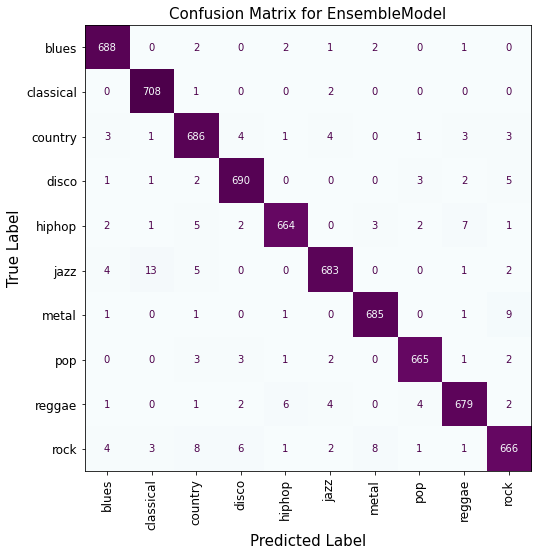




Train Data Report:

              precision    recall  f1-score   support

           0      0.977     0.989     0.983       696
           1      0.974     0.996     0.985       711
           2      0.961     0.972     0.966       706
           3      0.976     0.980     0.978       704
           4      0.982     0.967     0.974       687
           5      0.979     0.965     0.972       708
           6      0.981     0.981     0.981       698
           7      0.984     0.982     0.983       677
           8      0.976     0.971     0.973       699
           9      0.965     0.951     0.958       700

    accuracy                          0.975      6986
   macro avg      0.975     0.975     0.975      6986
weighted avg      0.975     0.975     0.975      6986



In [6]:
#Testing on Training Data
fig = model_report(en_model, test_data=False, conf_matrix=True, class_report=True)

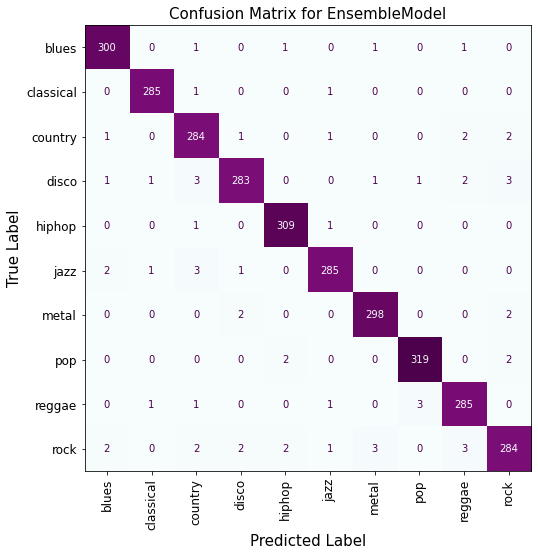




Test Data Report:

              precision    recall  f1-score   support

           0      0.980     0.987     0.984       304
           1      0.990     0.993     0.991       287
           2      0.959     0.976     0.968       291
           3      0.979     0.959     0.969       295
           4      0.984     0.994     0.989       311
           5      0.983     0.976     0.979       292
           6      0.983     0.987     0.985       302
           7      0.988     0.988     0.988       323
           8      0.973     0.979     0.976       291
           9      0.969     0.950     0.959       299

    accuracy                          0.979      2995
   macro avg      0.979     0.979     0.979      2995
weighted avg      0.979     0.979     0.979      2995



In [7]:
#Testing on Testing Data
fig = model_report(en_model, test_data=True, conf_matrix=True, class_report=True)

#Saving
path = os.path.join('Visualization', 'Ensembled_Confusion_Matrix.png')
fig.savefig(path, bbox_inches='tight', dpi=250)

### **Remarks**

Using the Ensembling approach we have increased our test accuracy from 91% to 98% without any additional training.

## Cohen's Kappa Statistics

- The traditional metrics from the classification report are biased towards the majority class and assumes an identical distribution of the actual and predicted classes. 

- In contrast, Cohen’s Kappa Statistic measures the proximity of the predicted classes to the actual classes

- The output is normalized between 0 and 1 the metrics for each classifier

- The closer to 1 the better is the classification

,Cohen's Kappa Statistics
XGBClassifier,0.969203
CatBoostClassifier,0.968461
RandomForestClassifier,0.938411
EnsembledClassifier,0.976625


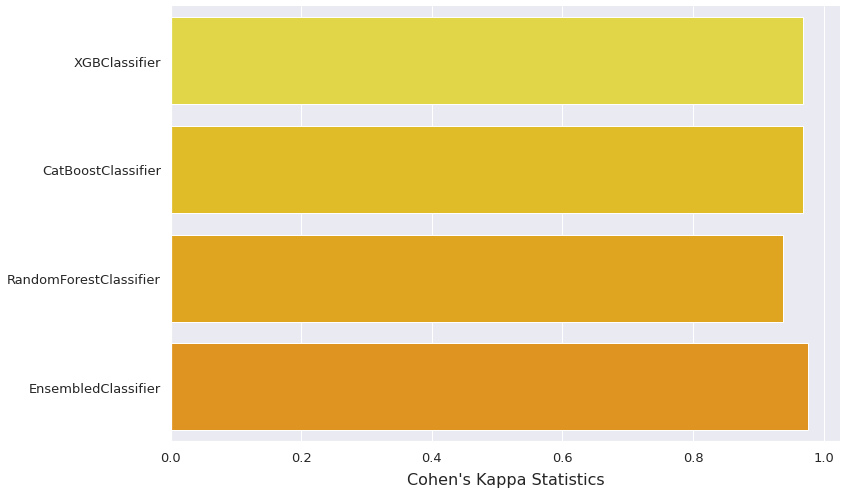

In [8]:
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import IPython.display as ipd

#XGB Kappa Score
y_pred_xgb = xgbc.predict(X_test)
xgbc_kappa = cohen_kappa_score(y_test, y_pred_xgb)

#CatBoost Kappa Score
y_pred_cbc = cbc.predict(X_test)
cbc_kappa = cohen_kappa_score(y_test, y_pred_cbc)

#Random Forest Kappa Score
y_pred_rfc = rfc.predict(X_test)
rfc_kappa = cohen_kappa_score(y_test, y_pred_rfc)

#Ensembled Model Kappa Score
y_pred_emc = en_model.predict(X_test)
emc_kappa = cohen_kappa_score(y_test, y_pred_emc)

data = {  "Cohen's Kappa Statistics" : [xgbc_kappa, cbc_kappa, rfc_kappa, emc_kappa]}

kappa = pd.DataFrame(data, index = ['XGBClassifier','CatBoostClassifier', 'RandomForestClassifier', 'EnsembledClassifier' ])

ipd.display(kappa)
print('\n\n')

#Visualizing
fig = plt.figure(figsize=(12,8))

sns.set(rc={'axes.spines.right' : False,'axes.spines.top' : False, 'axes.labelsize': 16,  'axes.labelpad': 8,
            'axes.grid': True, 'axes.edgecolor': 'white','grid.color': (1,1,1,0), 'xtick.labelsize': 13, 'ytick.labelsize': 13})

sns.barplot(data=kappa, x= "Cohen's Kappa Statistics", y=kappa.index, ax=plt.gca(), palette='Wistia');

### **Remarks**

As for Cohen's kappa, it was a tough fight among XGB(0.97), CatBoost(0.97), and Ensembled Model(0.98). But our ensembled model was slightly better than the former while the random forest classifier performed worst due to its over fitting tendencies

## Cross Entropy

- Cross-entropy measures the extent to which the predicted probabilities match the given data, and is useful for probabilistic classifiers such as Naïve Bayes. 
- It is a more generic form of the logarithmic loss function, which was derived from neural network architecture, and is used to quantify the cost of inaccurate predictions.

- The lower is the log loss the better is the classifier

,Cross Entropy
XGBClassifier,0.095687
CatBoostClassifier,0.117627
RandomForestClassifier,0.564919
EnsembledClassifier,0.200576


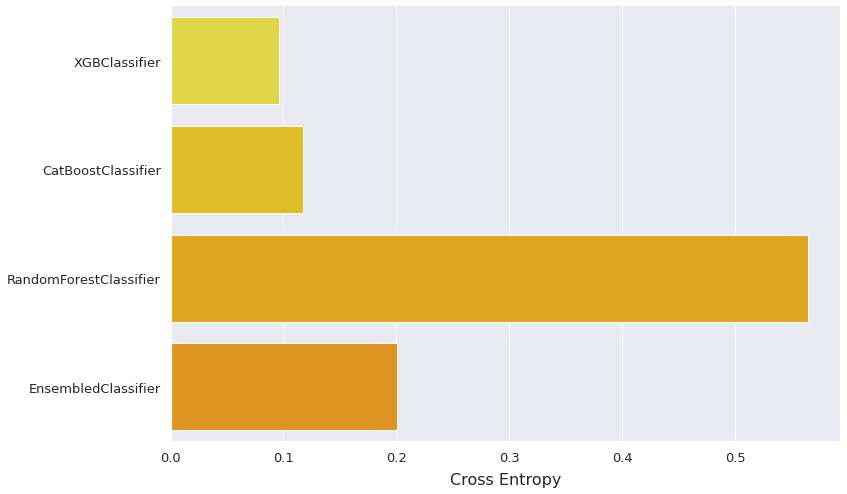

In [9]:
from sklearn.metrics import log_loss

#XGB MCC
y_probs_xgb = xgbc.predict_proba(X_test)
xgbc_ll = log_loss(y_test, y_probs_xgb)

#CatBoost MCC
y_probs_cbc = cbc.predict_proba(X_test)
cbc_ll = log_loss(y_test, y_probs_cbc)

#Random Forest MCC
y_probs_rfc = rfc.predict_proba(X_test)
rfc_ll = log_loss(y_test, y_probs_rfc)

#Ensembled Model MCC
y_probs_emc = en_model.predict_proba(X_test)
emc_ll= log_loss(y_test, y_probs_emc)

data = {"Cross Entropy" : [xgbc_ll, cbc_ll, rfc_ll, emc_ll]}

logloss = pd.DataFrame(data, index = kappa.index)

ipd.display(logloss)
print('\n\n')

#Visualizing
fig = plt.figure(figsize=(12,8))

sns.set(rc={'axes.spines.right' : False,'axes.spines.top' : False, 'axes.labelsize': 16,  'axes.labelpad': 8,
            'axes.grid': True, 'axes.edgecolor': 'white','grid.color': (1,1,1,0), 'xtick.labelsize': 13, 'ytick.labelsize': 13})

sns.barplot(data=logloss, x= "Cross Entropy", y=logloss.index, ax=plt.gca(), palette='Wistia');  

### **Remarks**

This was the most unexpected result. While random forest classifier was still the worst, XGBClassifier was in the lead instead of our ensembled model and Catboost was clase behind XGB. 

This is probably due to the fact that logloss or Cross Entropy is an intrinsic property of the modela and therefore propogates through ensembling techniques rather than reducing like overfitting, Cross Entropy was simply averaged out and hence the mediocre performance from our ensembled model.

# Final Comparison


In [10]:
#Combining Stats
acc = pd.DataFrame(data={'Accuracy' : [.91,.91,.85,.98]}, index=logloss.index) #Data from the Model_Building Notebook
stats = pd.concat([acc,logloss,kappa], axis='columns')
stats

,Accuracy,Cross Entropy,Cohen's Kappa Statistics
XGBClassifier,0.91,0.095687,0.969203
CatBoostClassifier,0.91,0.117627,0.968461
RandomForestClassifier,0.85,0.564919,0.938411
EnsembledClassifier,0.98,0.200576,0.976625


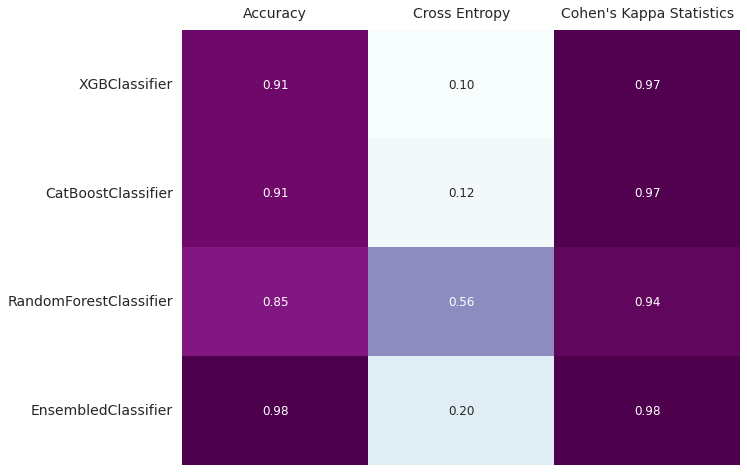

In [11]:
#Visualization
fig = plt.figure(figsize=(10,8))
sns.set(rc={'axes.labelsize': 16, 'axes.labelpad': 8, 'axes.grid': True, 'axes.edgecolor': 'white',
            'grid.color': (1,1,1,0), 'xtick.labelsize': 14, 'ytick.labelsize': 14, 
            'xtick.labeltop' : True, 'xtick.labelbottom': False})
sns.heatmap(stats,cmap='BuPu', annot=True,cbar=False, ax=plt.gca(), fmt='.2f');

#Saving
path = os.path.join('Visualization', 'Final_Comparison_Results.png')
fig.savefig(path, bbox_inches='tight', dpi=250)

# Results

- The Best Model is the Ensembled Model since it gives hightest accuracy and highest kappa with a comparable logloss

- XGBoost is a close alternative with worse accuracy and better kappa

- Catboost is proven to be the second best model right after XGBoost

- Random Forest is by far the worst performing in this study with the lowest accuracy and highest logloss